# Classifying surface EMG signals
## Using 1D convolutionnal neural networks

Adapted from Ladislas Nalborczyk (LPC, LNC, CNRS, AMU)


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Importing data
Data can be downloaded from GitHub either directly, or onto your computer then uploaded to the files tab 📁

In [5]:
%%bash
wget https://media.githubusercontent.com/media/lnalborczyk/ilcb_deep_learning_2022/master/data/x.csv
wget https://media.githubusercontent.com/media/lnalborczyk/ilcb_deep_learning_2022/master/data/y.csv

--2022-02-23 09:16:32--  https://media.githubusercontent.com/media/lnalborczyk/ilcb_deep_learning_2022/master/data/x.csv
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 105845801 (101M) [text/plain]
Saving to: ‘x.csv’

     0K .......... .......... .......... .......... ..........  0% 41.4M 2s
    50K .......... .......... .......... .......... ..........  0% 49.4M 2s
   100K .......... .......... .......... .......... ..........  0% 62.7M 2s
   150K .......... .......... .......... .......... ..........  0% 58.1M 2s
   200K .......... .......... .......... .......... ..........  0% 62.3M 2s
   250K .......... .......... .......... .......... ..........  0%  109M 2s
   300K .......... .......... .......... .......... ..........  0%  156M 2s
   350K .

In [6]:
# loading input features
x = pd.read_csv("x.csv")
print(x.shape)
x.head()

(2640, 2000)


,X1.1,X2.1,X3.1,X4.1,X5.1,X6.1,X7.1,X8.1,X9.1,X10.1,X11.1,X12.1,X13.1,X14.1,X15.1,X16.1,X17.1,X18.1,X19.1,X20.1,X21.1,X22.1,X23.1,X24.1,X25.1,X26.1,X27.1,X28.1,X29.1,X30.1,X31.1,X32.1,X33.1,X34.1,X35.1,X36.1,X37.1,X38.1,X39.1,X40.1,...,X961.2,X962.2,X963.2,X964.2,X965.2,X966.2,X967.2,X968.2,X969.2,X970.2,X971.2,X972.2,X973.2,X974.2,X975.2,X976.2,X977.2,X978.2,X979.2,X980.2,X981.2,X982.2,X983.2,X984.2,X985.2,X986.2,X987.2,X988.2,X989.2,X990.2,X991.2,X992.2,X993.2,X994.2,X995.2,X996.2,X997.2,X998.2,X999.2,X1000.2
0,-0.036024,0.000014,0.062766,0.113331,0.040279,-0.060853,-0.063413,0.013730,0.064268,0.082042,0.050287,0.025702,-0.084464,-0.221842,-0.148958,-0.065413,0.032227,0.072840,0.008059,0.167445,0.327317,0.256616,0.069338,-0.188139,-0.207538,-0.027176,-0.081127,-0.212371,-0.187106,-0.058972,0.085655,0.144203,0.054707,-0.063935,-0.065170,-0.023093,0.045563,0.069300,0.043454,0.027547,...,-0.000203,-0.001440,0.004908,0.004327,0.003270,0.001856,-0.001947,-0.003323,-0.001033,-0.001998,-0.004063,-0.001785,-0.001854,0.001184,0.000914,0.001027,0.003165,0.000702,-0.000128,-0.001410,-0.000503,-0.000774,0.000235,0.000782,-0.000236,0.000820,-0.000833,0.000404,0.000112,-0.001078,-0.000574,0.000334,0.002455,-0.000003,-0.001148,0.001041,0.001937,0.000644,-0.001675,-0.001406
1,0.078404,0.037125,0.017188,-0.033735,-0.024566,-0.026096,-0.025849,-0.028288,-0.036177,0.014963,0.054120,0.044820,0.030865,0.032262,0.023836,0.048525,0.039536,-0.028504,-0.059597,-0.047452,-0.003010,0.001870,-0.039376,-0.082873,-0.045674,0.049014,0.080762,0.017886,-0.049431,-0.012197,0.003803,-0.027885,-0.001783,0.039049,0.014720,-0.024802,-0.057904,-0.082305,-0.006491,0.140513,...,0.001430,0.001303,0.001205,0.000223,-0.000949,0.000427,0.000789,-0.000911,0.000957,-0.001730,-0.003031,-0.000634,0.003109,0.005547,0.002886,0.003233,0.004783,0.004990,-0.000189,-0.005267,-0.000468,0.002452,0.000688,-0.001299,-0.000421,-0.000899,-0.006160,-0.004711,0.002437,0.006031,0.007761,0.004713,-0.002286,-0.000811,0.002156,-0.000563,-0.004742,-0.005604,-0.005368,-0.006785
2,-0.001330,-0.040026,-0.042166,-0.040130,-0.037856,-0.030266,-0.023955,-0.008761,0.000905,0.010665,0.013927,0.019376,0.021689,0.017273,0.007296,-0.010394,-0.007700,0.013016,0.031935,0.034566,0.028280,0.021306,0.018799,0.016707,0.002203,-0.011364,-0.013112,-0.010130,-0.004129,-0.007754,-0.026807,-0.018863,-0.003892,-0.004116,-0.010310,-0.022992,-0.013495,-0.006763,-0.004772,0.014774,...,0.004410,0.002189,0.004453,0.007867,0.004260,0.001261,0.000055,-0.000739,0.001755,0.002956,0.003061,0.001988,0.000646,-0.000253,0.001312,0.004354,0.002705,0.001035,-0.000745,-0.002284,-0.003701,-0.002190,-0.001783,-0.003183,-0.000442,-0.002650,-0.006578,-0.005898,-0.001564,0.000598,-0.000375,-0.000565,0.000683,0.001245,0.000055,-0.001998,-0.004156,-0.000842,-0.000914,-0.000619
3,0.086723,0.012550,-0.082445,0.052253,0.122808,0.151215,0.055032,-0.088500,-0.131809,-0.234357,-0.189118,0.038631,0.236841,0.111770,0.032688,0.095694,-0.005635,-0.033029,-0.083581,-0.108058,-0.045794,-0.137595,-0.245800,-0.116243,0.033398,0.151857,0.505368,0.529828,0.096459,-0.123662,-0.208807,-0.176243,-0.059153,-0.158515,-0.267087,-0.127706,0.091066,0.109499,-0.004295,-0.147058,...,0.003363,0.000842,-0.001972,-0.001024,-0.003641,-0.001217,-0.000098,0.000318,0.000292,-0.000960,-0.001556,-0.001527,0.000338,0.000311,0.001938,0.000713,-0.000284,0.000063,0.001775,0.001999,-0.001797,0.001250,0.000937,0.000028,-0.000432,-0.003140,0.001838,0.004365,0.002538,-0.000904,0.000452,0.002603,0.001556,0.003221,0.000850,-0.001022,-0.001362,-0.001386,-0.000967,0.000195
4,-0.031001,-0.052560,-0.048220,-0.039191,-0.032562,-0.023029,0.016387,0.048946,0.040828,-0.013099,-0.069770,-0.070558,-0.051142,-0.027297,-0.009563,-0.003254,0.017374,0.032359,0.013125,-0.003162,0.019493,0.037914,0.037696,0.022078,-0.017856,-0.040705,-0.026647,-0.009982,-0.002654,0.001947,0.002492,0.001158,0.002734,0.009315,0.019246,0.045695,0.055891,0.031883,0.015728,0.001617,...,0.000507,0.001695,-0.000373,-0.0

Shape is supposed to be `(6 reps x 20 words x 22 participants) x 1 sec x 2 muscles` - duplicate features from conversion

In [7]:
x_1 = x[[col for col in x.columns if col[-2:] == '.1']].to_numpy()
x_2 = x[[col for col in x.columns if col[-2:] == '.2']].to_numpy()

In [8]:
x_reshaped = np.concatenate(
    [np.expand_dims(x_1, axis=2),
     np.expand_dims(x_2, axis=2)], axis=2
)
print(x_reshaped.shape)
# (6 reps x 20 words x 22 participants) x 1 sec x 2 muscles

(2640, 1000, 2)


In [9]:
# loading labels
y = pd.read_csv("y.csv")
print(y.shape)
# 6 reps x 20 words x 22 participants
y.head()

(2640, 1)


,x
0,1
1,1
2,1
3,1
4,1


### Splitting data into train/test


In [10]:
train_size = 0.8
num_classes = len(y.x.unique())
# Dummy encoding of labels
# takes a vector or 1 column matrix of class labels 
# and converts it into a matrix with p columns, one for each category.
y_categ = pd.get_dummies(y.x)

In [11]:
y_categ.head()

,0,1
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1


* Method 1: take the first 80% of rows

In [12]:
# train/test split (80%)
b = int(0.8 * x_reshaped.shape[0])
x_train = x_reshaped[:b,:,:]
x_test = x_reshaped[b:,:,:]

# train/test split
y_train = y_categ.iloc[:b]
y_test = y_categ.iloc[b:]

* Method 2: use the `scikit-learn` library to create random splits 

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
x_train, x_test, y_train, y_test = train_test_split(
    x_reshaped, y_categ, train_size=train_size # 0.8
)

### Create NN Model

Creates the 1D CNN model
with 1 temporal dimension and depth 2 (for OOI and ZYG muscles)

In [15]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D

In [16]:
model = Sequential()

# Adding layers
# input_shape should be [samples, time_steps, features]
model.add(Conv1D(filters=40, kernel_size=(10), strides=(2), padding="same", 
                 activation='relu', input_shape=(x_reshaped.shape[1],x_reshaped.shape[2])))
model.add(Dropout(0.2))
model.add(MaxPooling1D(pool_size=(3)))
model.add(Conv1D(filters=32, kernel_size=5, strides=2, 
                 padding="same", activation="relu"))
model.add(Dropout(0.2))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 500, 40)           840       
                                                                 
 dropout (Dropout)           (None, 500, 40)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 166, 40)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 83, 32)            6432      
                                                                 
 dropout_1 (Dropout)         (None, 83, 32)            0         
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                         

In [18]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [19]:
# x_train and y_train are Numpy arrays --just like in the Scikit-Learn API.
history = model.fit(x_train, y_train, epochs=20, batch_size=10, validation_split=0.2)

Epoch 1/20
169/169 [==============================] - 4s 20ms/step - loss: 0.6905 - accuracy: 0.5311 - val_loss: 0.6789 - val_accuracy: 0.5319
Epoch 2/20
169/169 [==============================] - 3s 15ms/step - loss: 0.6522 - accuracy: 0.6471 - val_loss: 0.6260 - val_accuracy: 0.6974
Epoch 3/20
169/169 [==============================] - 2s 11ms/step - loss: 0.5674 - accuracy: 0.7395 - val_loss: 0.5820 - val_accuracy: 0.6430
Epoch 4/20
169/169 [==============================] - 2s 11ms/step - loss: 0.4695 - accuracy: 0.8064 - val_loss: 0.4762 - val_accuracy: 0.7896
Epoch 5/20
169/169 [==============================] - 2s 11ms/step - loss: 0.4186 - accuracy: 0.8324 - val_loss: 0.4575 - val_accuracy: 0.7801
Epoch 6/20
169/169 [==============================] - 2s 11ms/step - loss: 0.3886 - accuracy: 0.8472 - val_loss: 0.4637 - val_accuracy: 0.7494
Epoch 7/20
169/169 [==============================] - 2s 11ms/step - loss: 0.3790 - accuracy: 0.8484 - val_loss: 0.4465 - val_accuracy: 0.7730

* validation accuracy is around 75% just using the OOI...
* validation accuracy is around 80% when using both the OOI and the ZYG...
* validation accuracy is around 80% when using all four facial muscles (OOI, ZYG, COR, FRO)...
* NB: it was 0.848 [0.816, 0.877] using random forest and all four facial muscles...

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


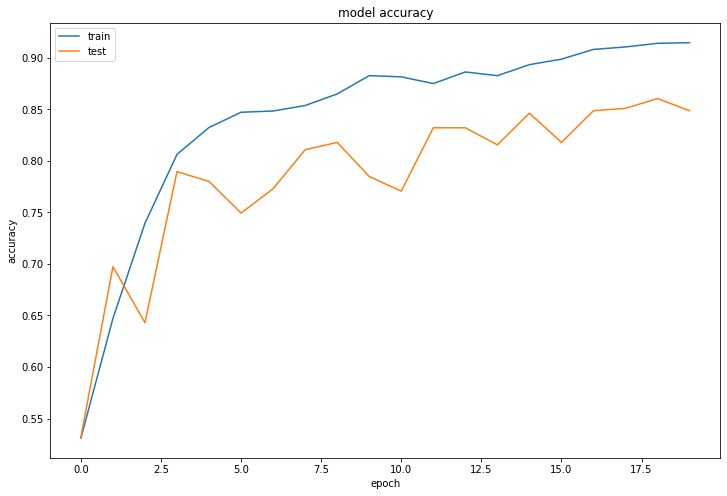

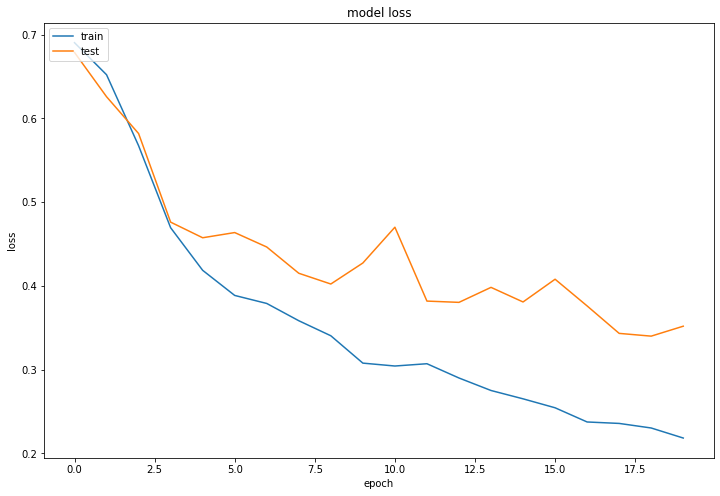

In [20]:
# plots evolution of accuracy and loss (categorical cross-entropy)
print(history.history.keys())

fig = plt.figure(figsize = (12,8))
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

fig = plt.figure(figsize = (12,8))
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Note: visualisation easier with R

### Evaluation

In [21]:
# evaluating the model's predictions
model.evaluate(x_test, y_test)

17/17 [==============================] - 0s 5ms/step - loss: 0.3367 - accuracy: 0.8523


[0.33672791719436646, 0.8522727489471436]

In [22]:
# makes predictions as probabilities and take the highr probability class
y_pred = model.predict(x_test).argmax(axis=-1)

In [23]:
 from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

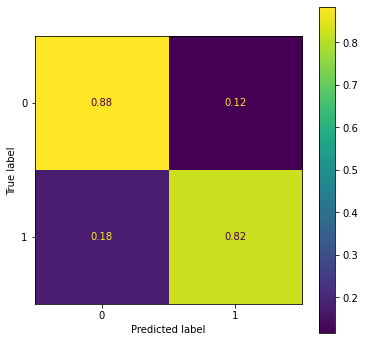

In [24]:
# confusion matrix
fig, ax = plt.subplots(figsize=(6,6))
cm = confusion_matrix(y_test[1], y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(0,10))
disp.plot(cmap='viridis', ax=ax)

### Save / Load models

In [25]:
from keras.models import Sequential, load_model, model_from_json
import json

In [26]:
# saves the entire model
model.save("emg_1d_cnn_model_overt.h5")
loaded_model = load_model("emg_1d_cnn_model_overt.h5")

# saves JSON config
json_string = model.to_json()
with open("emg_1d_cnn_model_config_overt.json", 'w') as outfile:
    outfile.write(json_string)